In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jaipaulchinthakuntla","key":"12baf4e1d0afa959c3b2690d16350d1d"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d cashbowman/ai-generated-images-vs-real-images
!unzip ai-generated-images-vs-real-images.zip -d dataset

Dataset URL: https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images
License(s): Community Data License Agreement - Sharing - Version 1.0
 94% 449M/476M [00:00<00:00, 373MB/s]
100% 476M/476M [00:01<00:00, 452MB/s]
Archive:  ai-generated-images-vs-real-images.zip
  inflating: dataset/AiArtData/AiArtData/-how-important-people-from-the-past-really-looked-11-Pics-5ffd5c0f4d77f__880.jpg  
  inflating: dataset/AiArtData/AiArtData/-s-fluffy-fur-and-round-features-immediately-melted-the-viewer-s-heart-photo.jpg  
  inflating: dataset/AiArtData/AiArtData/-using-generative-ai-technology-landscape-pattern-abstract-concept-269270897.jpg  
  inflating: dataset/AiArtData/AiArtData/-yellow-kimono-with-a-golden-crown-and-a-very-detailed-Barn-owl-copy-800x800.jpg  
  inflating: dataset/AiArtData/AiArtData/.amazonaws.com2Fpublic2Fimages2Ff89de3bb-279b-42c9-9822-a653fb5b21e6_600x480.png  
  inflating: dataset/AiArtData/AiArtData/0002_AI-in-animal-classification.png  
  inflating: da

In [3]:
# Essential libraries for deep learning and image processing
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
from tqdm.auto import tqdm
from io import BytesIO

# Verify PyTorch and CUDA setup
print("Setup Information:")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")

# Custom dataset class for AI vs Real images
class AIvsRealDataset(Dataset):
    def __init__(self, ai_path, real_path, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []

        # Load AI-generated images
        for root, _, files in os.walk(ai_path):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.images.append(os.path.join(root, file))
                    self.labels.append(1)  # 1 for AI-generated

        # Load real images
        for root, _, files in os.walk(real_path):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.images.append(os.path.join(root, file))
                    self.labels.append(0)  # 0 for real images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Create dataset instance
dataset = AIvsRealDataset(
    ai_path='/content/dataset/AiArtData/AiArtData',
    real_path='/content/dataset/RealArt/RealArt',
    transform=transform
)

# Print dataset statistics
print("\nDataset Information:")
print(f"Total images: {len(dataset)}")
print(f"AI images: {sum(1 for label in dataset.labels if label == 1)}")
print(f"Real images: {sum(1 for label in dataset.labels if label == 0)}")

Setup Information:
PyTorch Version: 2.6.0+cu124
CUDA Available: True
GPU Device: Tesla T4

Dataset Information:
Total images: 970
AI images: 536
Real images: 434


Displaying sample images from the dataset:


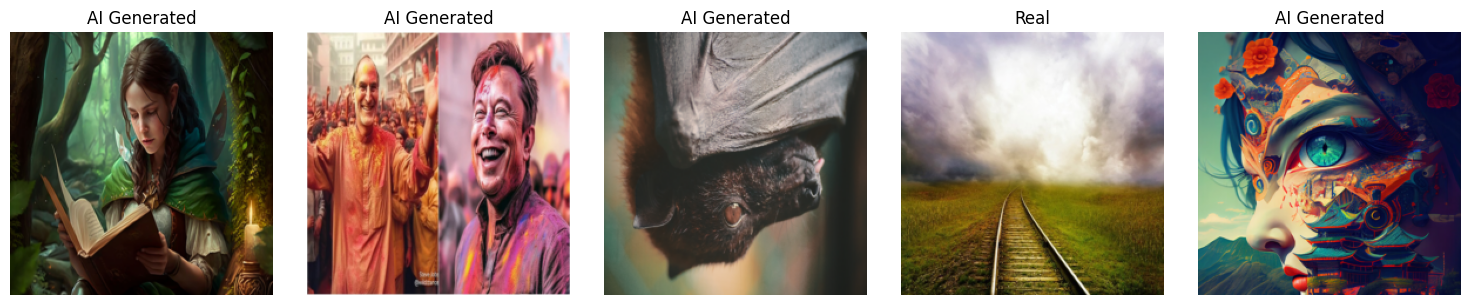

In [4]:
def show_sample_images(dataset, num_samples=5):
    plt.figure(figsize=(15, 3))

    # Create unnormalize transform
    unnormalize = transforms.Compose([
        transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
    ])

    for i in range(num_samples):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]

        # Unnormalize image for display
        img = unnormalize(img)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
        plt.title('AI Generated' if label == 1 else 'Real')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Displaying sample images from the dataset:")
show_sample_images(dataset)

In [5]:
class AIImageDetector(nn.Module):
    def __init__(self):
        super(AIImageDetector, self).__init__()

        # Feature extraction paths for different aspects
        self.detail_path = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.pattern_path = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.combined_features = nn.Sequential(
            nn.Conv2d(96, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Extract features
        details = self.detail_path(x)
        patterns = self.pattern_path(x)

        # Combine features
        combined = torch.cat([details, patterns], dim=1)
        features = self.combined_features(combined)

        # Classify
        x = features.view(features.size(0), -1)
        x = self.classifier(x)
        return x

# Create model and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AIImageDetector().to(device)

# Split dataset and create dataloaders
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [6]:
# Training function
from sklearn.metrics import f1_score


def train_model(model, train_loader, val_loader, num_epochs=10):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        all_train_preds = []
        all_train_labels = []

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            labels = labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())


        # Calculate F1 score
        train_f1 = f1_score(all_train_labels, all_train_preds)


        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        all_val_preds = []
        all_val_labels = []


        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).float()

                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs >= 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

            # Calculate F1 score
            val_f1 = f1_score(all_val_labels, all_val_preds)


        # Print epoch statistics
        print(f'\nEpoch {epoch+1}:')
        print(f'Training Loss: {train_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
        print(f'Train F1 Score: {train_f1:.4f}')
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100*val_correct/val_total:.2f}%')
        print(f'Validation F1 Score: {val_f1:.4f}')

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_ai_detector.pth')

# Train the model
train_model(model, train_loader, val_loader)

Epoch 1/10:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1:
Training Loss: 0.6653, Accuracy: 62.11%
Train F1 Score: 0.6832
Validation Loss: 0.6104, Accuracy: 59.28%
Validation F1 Score: 0.6393


Epoch 2/10:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 2:
Training Loss: 0.6417, Accuracy: 63.14%
Train F1 Score: 0.6996
Validation Loss: 0.5805, Accuracy: 64.43%
Validation F1 Score: 0.7206


Epoch 3/10:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 3:
Training Loss: 0.6378, Accuracy: 66.37%
Train F1 Score: 0.7057
Validation Loss: 0.5966, Accuracy: 61.86%
Validation F1 Score: 0.6442


Epoch 4/10:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 4:
Training Loss: 0.6285, Accuracy: 65.46%
Train F1 Score: 0.7208
Validation Loss: 0.5649, Accuracy: 65.98%
Validation F1 Score: 0.7250


Epoch 5/10:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 5:
Training Loss: 0.6196, Accuracy: 66.37%
Train F1 Score: 0.7226
Validation Loss: 0.5848, Accuracy: 65.46%
Validation F1 Score: 0.7491


Epoch 6/10:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 6:
Training Loss: 0.6229, Accuracy: 66.24%
Train F1 Score: 0.7115
Validation Loss: 0.5555, Accuracy: 64.95%
Validation F1 Score: 0.7043


Epoch 7/10:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 7:
Training Loss: 0.6186, Accuracy: 65.46%
Train F1 Score: 0.7061
Validation Loss: 0.5571, Accuracy: 65.98%
Validation F1 Score: 0.7080


Epoch 8/10:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 8:
Training Loss: 0.6243, Accuracy: 66.62%
Train F1 Score: 0.7212
Validation Loss: 0.6369, Accuracy: 56.19%
Validation F1 Score: 0.3885


Epoch 9/10:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 9:
Training Loss: 0.5982, Accuracy: 67.27%
Train F1 Score: 0.7263
Validation Loss: 0.5811, Accuracy: 64.95%
Validation F1 Score: 0.6964


Epoch 10/10:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 10:
Training Loss: 0.6062, Accuracy: 67.27%
Train F1 Score: 0.7203
Validation Loss: 0.5891, Accuracy: 65.46%
Validation F1 Score: 0.7331


In [7]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images).squeeze()
            predicted = (outputs >= 0.5).float()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'\nTest Accuracy: {accuracy:.2f}%')
    return accuracy, all_preds, all_labels

# Evaluate the model
print("Evaluating model on validation set:")
accuracy, preds, labels = evaluate_model(model, val_loader)
eval_f1 = f1_score(labels, preds)
print(f'Evaluation F1 Score: {eval_f1:.4f}')

Evaluating model on validation set:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Test Accuracy: 65.46%
Evaluation F1 Score: 0.7331



Testing model on futuristic tiger image:


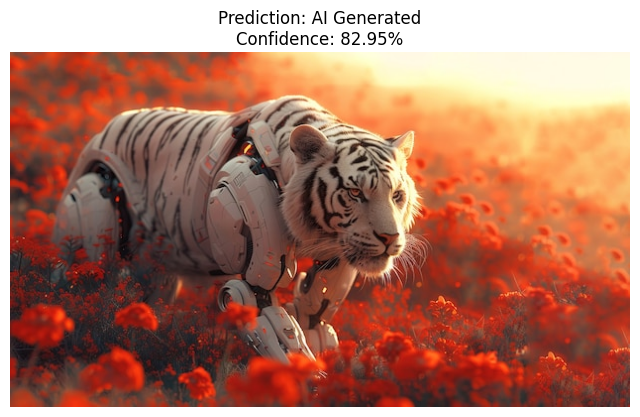

In [9]:
def test_single_image(model, image_url):
    # Download and process image
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    # img = Image.open("/content/Test_Images/Test_Image_01.png").convert('RGB')
    # Transform image
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor).squeeze()
        prediction = output.item()

    # Display results
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediction: {"AI Generated" if prediction >= 0.5 else "Real"}\n'
              f'Confidence: {max(prediction, 1-prediction):.2%}')
    plt.show()

# Test the tiger image
tiger_url = "https://img.freepik.com/free-photo/futuristic-half-robot-tiger_23-2151558816.jpg"
print("\nTesting model on futuristic tiger image:")
test_single_image(model, tiger_url)

# image_url2 = "/content/Test Images/01.jpg"
# test_single_image(model, image_url2)